# XGBoost Model
This notebook trains and evaluates an XGBoost regression model
to improve predictive performance beyond bagging-based ensembles.

## 0. Import Libraries

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import xgboost as xgb

from sklearn.pipeline import Pipeline

## 1. Load Processed Data

In [4]:
DATA_PATH = "../data/processed/flight_prices_processed.csv"
df = pd.read_csv(DATA_PATH)

df.shape, df.columns
df.head()

,Airline,Source,Destination,Total_Stops,Price,Price_USD,Duration_min,Journey_day,Journey_month,Dep_hour,Dep_min,Arr_hour,Arr_min
0,IndiGo,Banglore,New Delhi,0,3897,46.764,170,24,3,22,20,1,10
1,Air India,Kolkata,Banglore,2,7662,91.944,445,1,5,5,50,13,15
2,Jet Airways,Delhi,Cochin,2,13882,166.584,1140,9,6,9,25,4,25
3,IndiGo,Kolkata,Banglore,1,6218,74.616,325,12,5,18,5,23,30
4,IndiGo,Banglore,New Delhi,1,13302,159.624,285,1,3,16,50,21,35


## 2. Define Target and Features

In [5]:
target = "Price_USD"
X = df.drop(columns=["Price_USD", "Price"], errors="ignore")
y = df[target].astype(float)

## 3. Trim Extreme Targets

In [6]:
USE_TRIM = True

if USE_TRIM:
    mask = y <= 600
    X = X.loc[mask].copy()
    y = y.loc[mask].copy()

X.shape, y.shape

((10657, 11), (10657,))

## 4. Train-Test split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## 5. Preprocessing

In [10]:
cat_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols),
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median"))
        ]), num_cols),
    ],
    remainder="drop"
)

pre_fit = preprocess.fit(X_train)
X_train_trans = pre_fit.transform(X_train)
X_test_trans = pre_fit.transform(X_test)

dtrain = xgb.DMatrix(X_train_trans, label=y_train)
dtest  = xgb.DMatrix(X_test_trans,  label=y_test)

## 6. Baseline XGBoost

In [11]:
params_base = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "eta": 0.10,
    "max_depth": 6,
    "tree_method": "hist",
    "seed": 111111
}

num_boost_round = 300
booster_base = xgb.train(params_base, dtrain, num_boost_round=num_boost_round)

pred = booster_base.predict(dtest)

rmse = np.sqrt(mean_squared_error(y_test, pred))
mae  = mean_absolute_error(y_test, pred)
r2   = r2_score(y_test, pred)

print({"rmse": rmse, "mae": mae, "r2": r2})

{'rmse': np.float64(19.2081802827664), 'mae': 12.986549263093528, 'r2': 0.8637593052866306}


## 7. Diagnostics

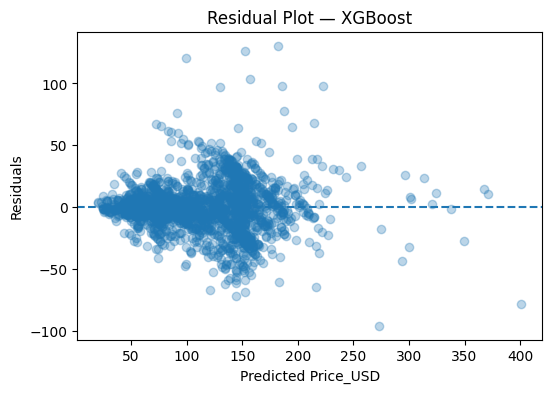

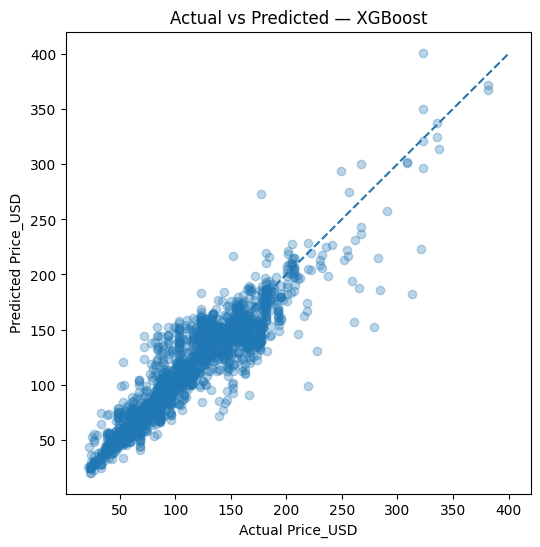

In [12]:
residuals = y_test - pred

plt.figure(figsize=(6,4))
plt.scatter(pred, residuals, alpha=0.3)
plt.axhline(0, linestyle="--")
plt.xlabel("Predicted Price_USD")
plt.ylabel("Residuals")
plt.title("Residual Plot — XGBoost")
plt.show()

plt.figure(figsize=(6,6))
plt.scatter(y_test, pred, alpha=0.3)
mn, mx = float(min(y_test.min(), pred.min())), float(max(y_test.max(), pred.max()))
plt.plot([mn, mx], [mn, mx], linestyle="--")
plt.xlabel("Actual Price_USD")
plt.ylabel("Predicted Price_USD")
plt.title("Actual vs Predicted — XGBoost")
plt.show()

## 8. Cross-Validation for Optimal Boosting Rounds

[0]	train-rmse:48.99394+0.16671	test-rmse:49.06535+0.67486
[20]	train-rmse:23.33395+0.18379	test-rmse:24.67311+0.65725
[40]	train-rmse:20.00804+0.18561	test-rmse:22.24926+0.81757
[60]	train-rmse:18.48691+0.17618	test-rmse:21.56302+0.82672
[80]	train-rmse:17.55810+0.22684	test-rmse:21.22597+0.83845
[100]	train-rmse:16.80613+0.19929	test-rmse:21.00657+0.90485
[120]	train-rmse:16.21649+0.24465	test-rmse:20.85597+0.87843
[140]	train-rmse:15.64679+0.23284	test-rmse:20.81538+0.91404
[160]	train-rmse:15.15269+0.24637	test-rmse:20.79274+0.94092
[180]	train-rmse:14.73297+0.23888	test-rmse:20.74042+0.96902
[200]	train-rmse:14.38509+0.22366	test-rmse:20.78390+0.96266
Best round: 181
Best CV RMSE: 20.740420003887373


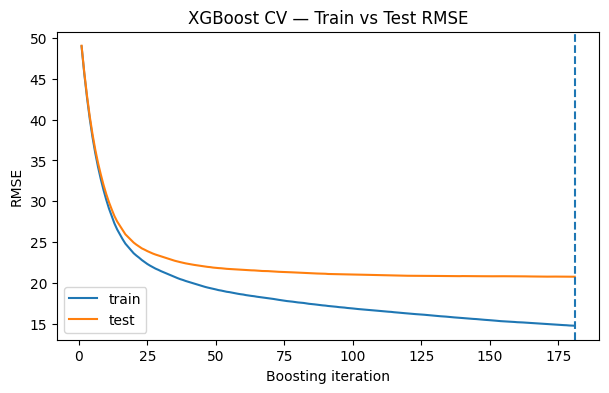

In [13]:
cv_params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "eta": 0.10,
    "max_depth": 6,
    "tree_method": "hist",
    "seed": 111111
}

cv_res = xgb.cv(
    params=cv_params,
    dtrain=dtrain,
    num_boost_round=400,
    nfold=5,
    shuffle=True,
    early_stopping_rounds=20,
    verbose_eval=20
)

best_round = len(cv_res)
best_rmse = float(cv_res["test-rmse-mean"].iloc[-1])
print("Best round:", best_round)
print("Best CV RMSE:", best_rmse)

plt.figure(figsize=(7,4))
plt.plot(np.arange(1, len(cv_res)+1), cv_res["train-rmse-mean"], label="train")
plt.plot(np.arange(1, len(cv_res)+1), cv_res["test-rmse-mean"],  label="test")
plt.axvline(best_round, linestyle="--")
plt.xlabel("Boosting iteration")
plt.ylabel("RMSE")
plt.title("XGBoost CV — Train vs Test RMSE")
plt.legend()
plt.show()

## 9. Lightweight Tuning

### 9-1. max_depth × min_child_weight

In [14]:
grid_1 = list(ParameterGrid({
    "max_depth": [3, 6],
    "min_child_weight": [5, 7]
}))

base_params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "eta": 0.10,
    "tree_method": "hist",
    "seed": 111111
}

def run_cv(params):
    cv = xgb.cv(
        params=params,
        dtrain=dtrain,
        num_boost_round=300,
        nfold=5,
        early_stopping_rounds=20,
        shuffle=True,
        verbose_eval=False,
        seed=111111
    )
    return len(cv), float(cv["test-rmse-mean"].iloc[-1])

rows = []
for g in grid_1:
    p = base_params.copy()
    p.update(g)
    br, rm = run_cv(p)
    rows.append({**g, "best_round": br, "cv_rmse": rm})

res1 = pd.DataFrame(rows).sort_values("cv_rmse").reset_index(drop=True)
res1
best1 = res1.iloc[0].to_dict()
best1

{'max_depth': 6.0,
 'min_child_weight': 7.0,
 'best_round': 234.0,
 'cv_rmse': 20.645889888048583}

### 9-2. gamma

In [16]:
gamma_vals = [0.0, 0.05, 0.10, 0.15]
rows = []
for gamma in gamma_vals:
    p = base_params.copy()
    p.update({
        "max_depth": int(best1["max_depth"]),
        "min_child_weight": int(best1["min_child_weight"]),
        "gamma": float(gamma)
    })
    br, rm = run_cv(p)
    rows.append({"gamma": gamma, "best_round": br, "cv_rmse": rm})

res2 = pd.DataFrame(rows).sort_values("cv_rmse").reset_index(drop=True)
res2
best2 = res2.iloc[0].to_dict()
best2

{'gamma': 0.15, 'best_round': 211.0, 'cv_rmse': 20.640079471041187}

### 9-3. subsample × colsample_bytree

In [17]:
grid_3 = list(ParameterGrid({
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0]
}))

rows = []
for g in grid_3:
    p = base_params.copy()
    p.update({
        "max_depth": int(best1["max_depth"]),
        "min_child_weight": int(best1["min_child_weight"]),
        "gamma": float(best2["gamma"]),
        **g
    })
    br, rm = run_cv(p)
    rows.append({**g, "best_round": br, "cv_rmse": rm})

res3 = pd.DataFrame(rows).sort_values("cv_rmse").reset_index(drop=True)
res3.head()
best3 = res3.iloc[0].to_dict()
best3

{'colsample_bytree': 0.6,
 'subsample': 1.0,
 'best_round': 300.0,
 'cv_rmse': 20.389800194634688}

## 10. Final Model

In [18]:
final_params = base_params.copy()
final_params.update({
    "max_depth": int(best1["max_depth"]),
    "min_child_weight": int(best1["min_child_weight"]),
    "gamma": float(best2["gamma"]),
    "subsample": float(best3["subsample"]),
    "colsample_bytree": float(best3["colsample_bytree"]),
    "eta": 0.10
})

final_round = int(best3["best_round"])  # 마지막 튜닝에서 나온 best_round 사용
booster_final = xgb.train(final_params, dtrain, num_boost_round=final_round)

pred = booster_final.predict(dtest)

rmse = np.sqrt(mean_squared_error(y_test, pred))
mae  = mean_absolute_error(y_test, pred)
r2   = r2_score(y_test, pred)

print({"rmse": rmse, "mae": mae, "r2": r2, "best_round": final_round})

{'rmse': np.float64(18.831064316477377), 'mae': 13.05791255265284, 'r2': 0.8690564423061895, 'best_round': 300}


## 11. Feature Importance

<Figure size 700x500 with 0 Axes>

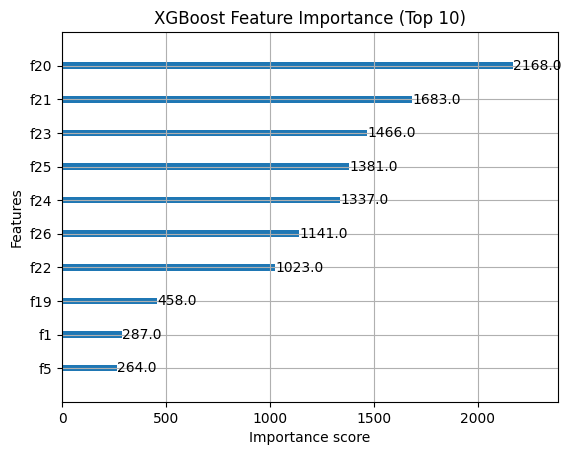

In [19]:
plt.figure(figsize=(7,5))
xgb.plot_importance(booster_final, max_num_features=10)
plt.title("XGBoost Feature Importance (Top 10)")
plt.show()

## 12. Summary

- Cross-validation was applied to select an appropriate number of boosting rounds and to tune key tree/regularization parameters. 
- The final model improves flexibility beyond bagging while maintaining a structured tuning process.